In [0]:
!pip install torch torchvision


In [0]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms 

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [0]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_dataset = datasets.CIFAR100(root='./data',train=True,download=True,transform=transform_train)
validation_dataset = datasets.CIFAR100(root='./data',train=False,download=True,transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=100,shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=100,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  #print(image.shape)
  #retirar a normalização
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [0]:
dataiter = iter(training_loader)
images,labels = dataiter.next()
print(labels[0].item())

28


In [0]:
classes = (
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
    )

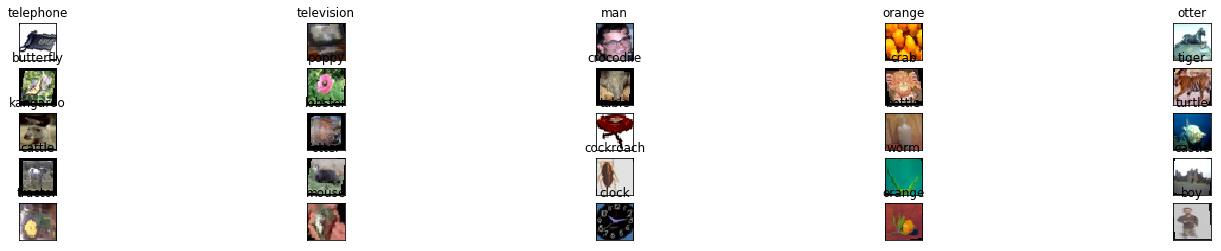

In [0]:
dataiter = iter(training_loader)
images,labels = dataiter.next()

fig = plt.figure(figsize=(25,4))

for idx in np.arange(25):
  ax = fig.add_subplot(5,5,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,1,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,1,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,1,padding=1)
    self.fc1 = nn.Linear(4*4*64,500)
    self.dropout1 = nn.Dropout(0.5) #colocar dropout pra evirar overfitting (colocar onde há bastante parametros)
    self.fc2 = nn.Linear(500,100)  #o segundo numero é o numero de classes  
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)#colocar dropout pra evirar overfitting (colocar onde há bastante parametros)
    x = self.fc2(x)
    return x
  

In [0]:
model = LeNet().to(device)
model

#import torchvision.models as models
#resnet18 = models.resnet18(pretrained=True)
#model = resnet18
#model


LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
)

In [0]:
import time
start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

print('levou {} segundos '.format(time.time() - start_time))

levou 0.0008232593536376953 segundos 


In [0]:
CUDA_LAUNCH_BLOCKING=1

import time
start_time = time.time()



epochs = 15

running_loss_history=[]
running_corrects_history=[]

val_running_loss_history=[]
val_running_corrects_history=[]


for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _,preds = torch.max(outputs,1)    
    running_loss += loss.item()
    running_corrects+= torch.sum(preds == labels.data)    
    
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_labels)        
        
        _,val_preds = torch.max(val_outputs,1)
        val_running_loss += val_loss.item()
        val_running_corrects+= torch.sum(val_preds == val_labels.data)  
      
    epoch_loss = running_loss/len(training_loader)
    #epoch_loss = calcula o loss function atual
    epoch_acc = running_corrects.float()/len(training_loader)
    #epoch_acc = pega a quantiade de acertos que teve em relacao ao total e seta a porcentagem de acertos
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    #epoch_loss = calcula o loss function atual
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    #epoch_acc = pega a quantiade de acertos que teve em relacao ao total e seta a porcentagem de acertos
    val_running_loss_history.append(val_epoch_loss)    
    val_running_corrects_history.append(val_epoch_acc)    
    
    print('epoch: ',str(e+1))
    print('training_loss: {:.4f},{:.4f}'.format(epoch_loss,epoch_acc.item()))
    print('validation_loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))
    print('difference between loss:', val_epoch_loss-epoch_loss)

    
print('levou {} segundos '.format(time.time() - start_time))

epoch:  1
training_loss: 4.0600,7.8680
validation_loss: 3.6844, validation acc 13.6700
difference between loss: -0.375613925933838
epoch:  2
training_loss: 3.5473,15.7640
validation_loss: 3.3474, validation acc 19.6400
difference between loss: -0.19993145751953145
epoch:  3
training_loss: 3.3195,19.5380
validation_loss: 3.1682, validation acc 22.3300
difference between loss: -0.15131248998641977
epoch:  4
training_loss: 3.1699,22.5320
validation_loss: 3.0369, validation acc 25.8600
difference between loss: -0.13298321104049693
epoch:  5
training_loss: 3.0699,24.4300
validation_loss: 2.9713, validation acc 26.1900
difference between loss: -0.0986778202056886
epoch:  6
training_loss: 2.9750,26.0960
validation_loss: 2.9078, validation acc 28.3500
difference between loss: -0.06720662450790416
epoch:  7
training_loss: 2.9074,27.8340
validation_loss: 2.8496, validation acc 29.3700
difference between loss: -0.05782476282119742
epoch:  8
training_loss: 2.8490,28.5460
validation_loss: 2.7646, v

In [0]:
#training_loss: 0.8267,71.0100
#validation_loss: 0.7724, validation acc 73.7500
#difference between loss: -0.0543566477298737

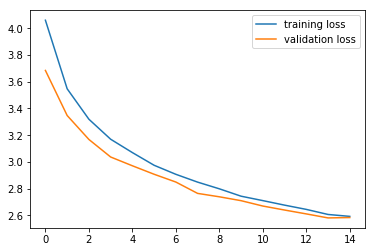

In [0]:
plt.plot(running_loss_history,label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()


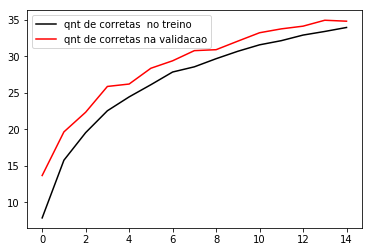

In [0]:
plt.plot(running_corrects_history,label='qnt de corretas  no treino',color="black")
plt.plot(val_running_corrects_history,label='qnt de corretas na validacao', color='red')
plt.legend()

https://i.imgur.com/L93iqLv.jpg <Response [200]>
https://i.imgur.com/5I6c1Xf.jpg <Response [200]>


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


https://i.imgur.com/zClfNPb.jpg <Response [200]>
https://www.petlove.com.br/dicas/wp-content/uploads/2018/05/golden-idoso.jpg <Response [200]>
http://data.biovet.com.br/file/2018/10/29/H104520-F00000-V006-2000x0.jpeg <Response [200]>
https://s.hdnux.com/photos/75/50/00/16154647/5/920x920.jpg <Response [200]>
https://d.newsweek.com/en/full/1336950/deer-zombie-deer-chronic-wasting-disease.jpg <Response [200]>
https://d39w7f4ix9f5s9.cloudfront.net/b3/d0/80815f4d46cfbf551f19719fedd9/20160808primeairplaneinflight-20.JPG <Response [200]>
https://www.gazetadopovo.com.br/viver-bem/wp-content/uploads/2017/03/como-dar-banho-em-gato-600x401.jpg <Response [200]>
https://conteudo.imguol.com.br/c/entretenimento/0b/2019/03/08/goose-o-gato-da-capita-marvel-1552070006188_v2_450x600.jpg <Response [200]>
https://www.gazetadopovo.com.br/viver-bem/wp-content/uploads/2018/07/gato-esfinge-foto-unsplash-600x400.jpg <Response [200]>
https://thenypost.files.wordpress.com/2019/08/frogs-in-packaged-salads.jpg?qua

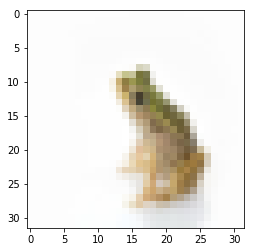

In [0]:
import requests
from PIL import Image
import PIL.ImageOps

externalPhotos = [] 

externalPhotos.append('https://i.imgur.com/L93iqLv.jpg')
externalPhotos.append('https://i.imgur.com/5I6c1Xf.jpg')
externalPhotos.append('https://i.imgur.com/zClfNPb.jpg')

externalPhotos.append('https://www.petlove.com.br/dicas/wp-content/uploads/2018/05/golden-idoso.jpg')
externalPhotos.append('http://data.biovet.com.br/file/2018/10/29/H104520-F00000-V006-2000x0.jpeg')

externalPhotos.append('https://s.hdnux.com/photos/75/50/00/16154647/5/920x920.jpg')
externalPhotos.append('https://d.newsweek.com/en/full/1336950/deer-zombie-deer-chronic-wasting-disease.jpg')
externalPhotos.append('https://d39w7f4ix9f5s9.cloudfront.net/b3/d0/80815f4d46cfbf551f19719fedd9/20160808primeairplaneinflight-20.JPG')


externalPhotos.append('https://www.gazetadopovo.com.br/viver-bem/wp-content/uploads/2017/03/como-dar-banho-em-gato-600x401.jpg')
externalPhotos.append('https://conteudo.imguol.com.br/c/entretenimento/0b/2019/03/08/goose-o-gato-da-capita-marvel-1552070006188_v2_450x600.jpg')
externalPhotos.append('https://www.gazetadopovo.com.br/viver-bem/wp-content/uploads/2018/07/gato-esfinge-foto-unsplash-600x400.jpg')


externalPhotos.append('https://thenypost.files.wordpress.com/2019/08/frogs-in-packaged-salads.jpg?quality=90&strip=all&w=618&h=410&crop=1')
externalPhotos.append('https://ichef.bbci.co.uk/news/976/cpsprodpb/ED57/production/_106895706_14e3bcc8-283e-447e-a7c9-5047dbe732bf.jpg')
externalPhotos.append('https://le-www-live-s.legocdn.com/sc/media/lessons/wedo-2/wedo-projects/images/frogs-metamorphosis-project-image-feb9db40c70bcda57e12f5671d4bc278.jpg')


externalPhotos.append('https://www.petmd.com/sites/default/files/frog-care-101.jpg')




comparisonPhotos = []


for i in externalPhotos:  
  ax = fig.add_subplot(40,10,idx+1,xticks=[],yticks=[])
  
  response = requests.get(i,stream = True)  
  img = Image.open(response.raw)
  plt.imshow(img)
  print(i,response)  
  #imag = transform(img)
  comparisonPhotos.append(img)  
  imag = transform(img)
  plt.imshow(im_convert(imag))
  
  ax.set_title(idx)

#for idx in np.arange(len(comparisonPhotos)):
#  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
#  response = requests.get(externalPhotos[idx],stream = True)
#  img = Image.open(response.raw)
#  plt.imshow(img)
#  ax.set_title(idx)


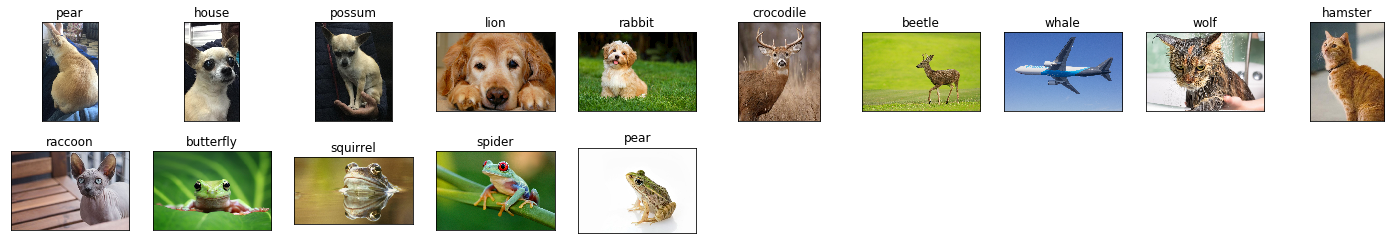

In [0]:
fig = plt.figure(figsize=(25,4))

acertos = 0
erros = 0

for idx in np.arange(len(comparisonPhotos)):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(comparisonPhotos[idx])   
  imag = transform(comparisonPhotos[idx])  
  image = imag.to(device).unsqueeze(0)
  output = model(image)
  _, pred = torch.max(output, 1)
  ax.set_title(classes[pred.item()])  
  

acertos: 35 
erros:65


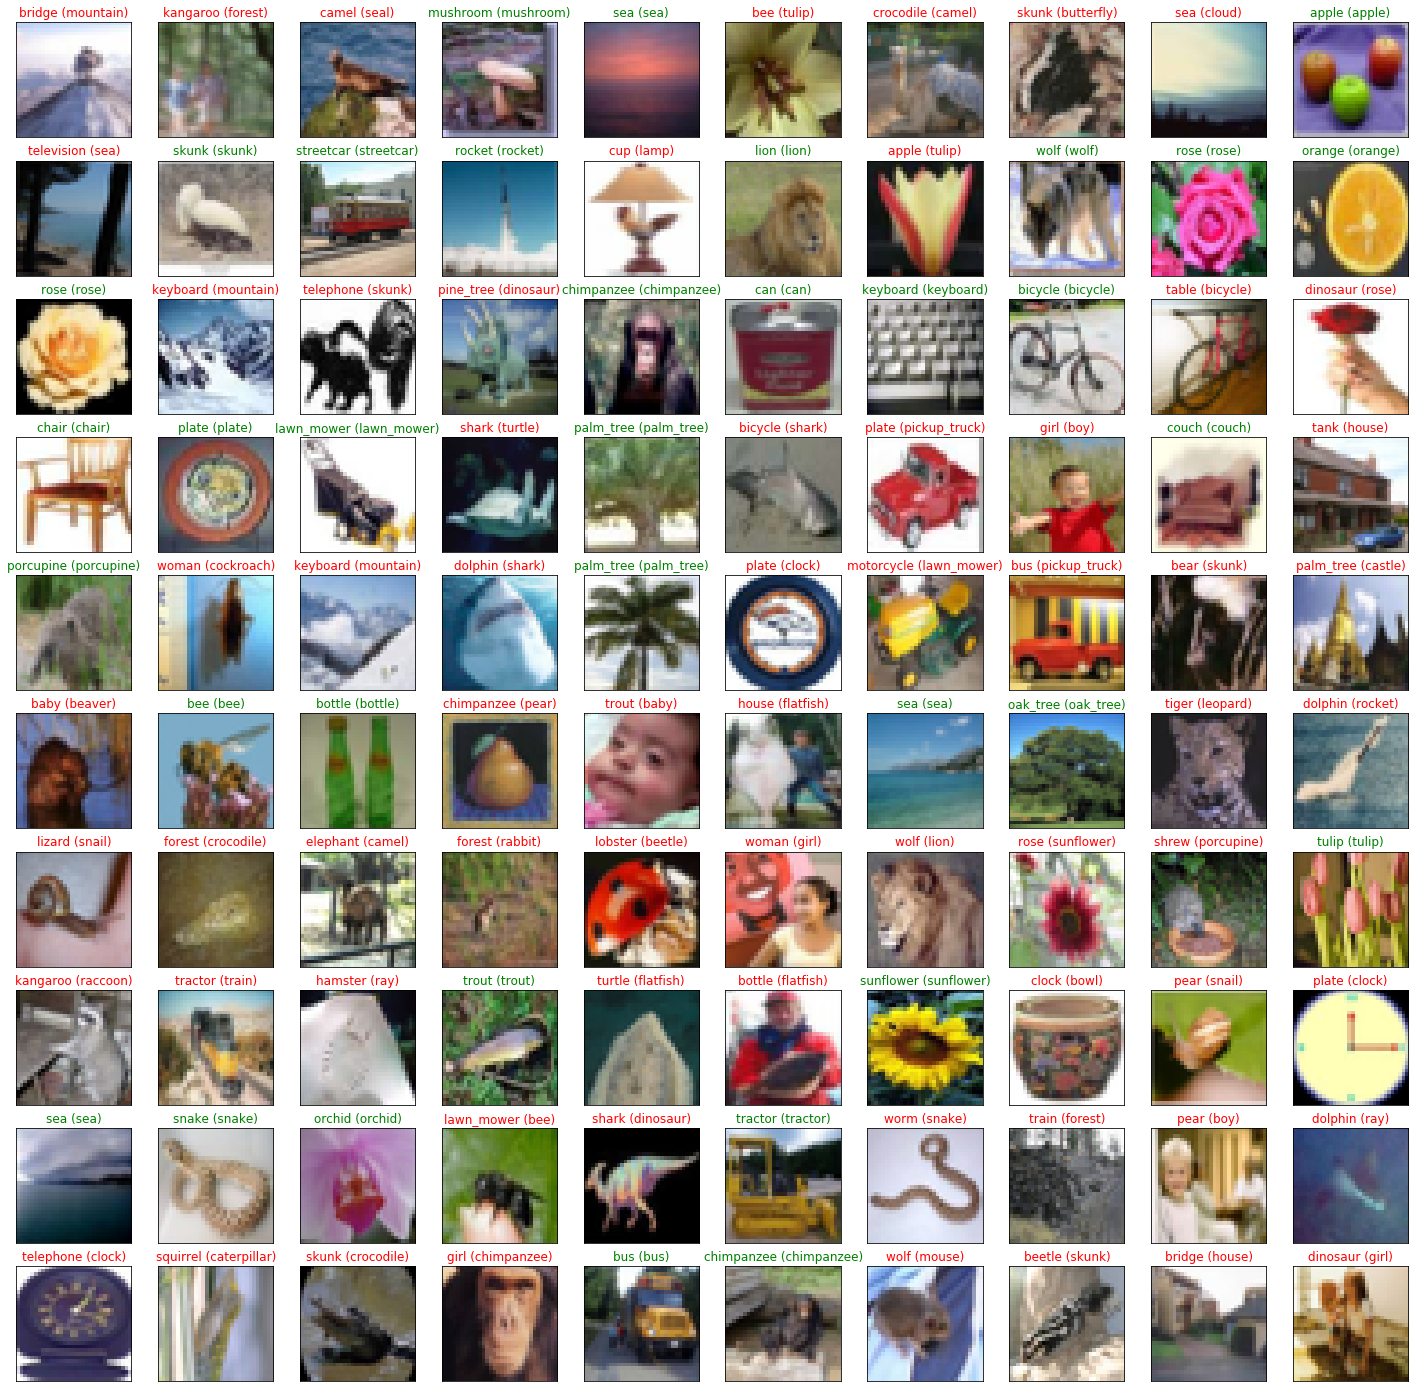

In [0]:
dataiter = iter(validation_loader)
images,labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_,preds = torch.max(output,1)

fig = plt.figure(figsize=(25,25))

acertos = 0
erros = 0

for idx in np.arange(100):
  ax = fig.add_subplot(10,10,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]))  
  if preds[idx]==labels[idx]:
    acertos = acertos +1
  else:
    erros = erros +1
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=('green' if preds[idx]==labels[idx] else "red"))
  
print('acertos: {} \nerros:{}'.format(acertos,erros))

In [0]:
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in dataiter:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of apple : 75 %
Accuracy of aquarium_fish : 60 %
Accuracy of  baby :  0 %
Accuracy of  bear : 20 %
Accuracy of beaver :  0 %
Accuracy of   bed :  0 %
Accuracy of   bee : 40 %
Accuracy of beetle : 28 %
Accuracy of bicycle : 100 %
Accuracy of bottle :  0 %
Accuracy of  bowl : 25 %
Accuracy of   boy : 50 %
Accuracy of bridge : 33 %
Accuracy of   bus : 40 %
Accuracy of butterfly :  0 %
Accuracy of camel :  0 %
Accuracy of   can :  0 %
Accuracy of castle :  0 %
Accuracy of caterpillar : 33 %
Accuracy of cattle :  0 %
Accuracy of chair : 80 %
Accuracy of chimpanzee : 100 %
Accuracy of clock : 50 %
Accuracy of cloud : 50 %
Accuracy of cockroach : 50 %
Accuracy of couch : 50 %
Accuracy of  crab : 16 %
Accuracy of crocodile : 50 %
Accuracy of   cup : 66 %
Accuracy of dinosaur :  0 %
Accuracy of dolphin :  0 %
Accuracy of elephant : 33 %
Accuracy of flatfish : 66 %
Accuracy of forest : 20 %
Accuracy of   fox : 20 %
Accuracy of  girl : 20 %
Accuracy of hamster : 50 %
Accuracy of house : 